# Training Deep Neural Networks on a GPU

In this notebook we'll train a neural network of three layers: input layer, output layer, and a hidden layer to identify handwritten digits from MNIST dataset. We also use GPU to train our model if available.

![neural network](images/neural_network.svg)

The workflow to predict output class from input units is presented in the figure below.

![neural network workflow](images/neural_network_workflow.svg)

1. Input units are passed to a activation function to compute activation units of the hidden layer. In this problem, we choose RELU (Rectified Linear Unit) function as activation function.
2. Activation units are passed to a linear function to compute the linear predictions. These values then passed to softmax function to calculate probabilities belonging to output classes. The class having maximal probability will be considered as the prediction.

**NOTE:**
- If we choose a linear function as activation function, the neural network will become the logistic regression since the combination of two linear functions is a linear function.
- RELU is a non-linear function. $relu(x) = max(0,x)$
- Softmax function rescales an n-dimensional value so that its elements lie in the range $[0, 1]$ and sum to 1. $Softmax(x_i) = \frac{e^{x_i}}{\sum_j e^{x_j}}$

## Import libraries

In [1]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torch

## 1. Prepare data

### 1.1 Download data

In [2]:
dataset = MNIST(root="data/", train=True, transform=ToTensor(), download=True)
test_ds = MNIST(root="data/", train=False, transform=ToTensor())

### 1.2 Explorer data

image shape = [1, 28, 28]
label = 5


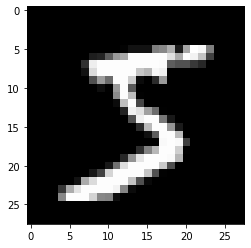

In [3]:
img, label = dataset[0]
print("image shape = %s" % list(img.shape))
print("label = %s" % label)
plt.imshow(img[0], cmap="gray");

In [4]:
print("dataset size = %s" % len(dataset))
print("testset size = %s" % len(test_ds))

dataset size = 60000
testset size = 10000


### 1.3 Split dataset to training & validation sets

In [5]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

### 1.4 Create data loaders

In [6]:
batch_size = 128

In [7]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

## 2. Define neural network

In [8]:
class MnistModel(nn.Module):
    def __init__(self, in_features:int, hidden_size:int, out_classes:int):
        super().__init__()
        self.linear1 = nn.Linear(in_features, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_classes)
    
    def forward(self, X:torch.tensor) -> torch.tensor:
        """Compute linear prediction of image(s)
        
        Args:
            X (torch.tensor): input image(s)
            
        Returns:
            torch.tensor: linear prediction of image(s)
        """
        # flatten image(s)
        X = X.reshape(-1, self.linear1.in_features)
        # compute activation units
        Z = self.linear1(X)
        A = F.relu(Z)
        # compute probabilities
        Y_linear = self.linear2(A)
        return Y_linear
    
    def predict(self, X:torch.tensor) -> torch.tensor:
        """Predict class(es) of image(s)
        
        Args:
            X (torch.tensor): input image(s)
            
        Returns:
            torch.tensor: class(es) predicted
        """
        Y_linear = self(X)
        probs = F.softmax(Y_linear.detach(), dim=1)
        _, Y_hat = torch.max(probs, dim=1)
        return Y_hat
    
    def cost_func(self, batch:list) -> torch.tensor:
        """Compute cost of prediction(s)
        
        Args:
            batch (list): containing 2 values images & labels
            
        Returns:
            torch.tesor: the cost
        """
        images, labels = batch
        Y_linear = self(images)
        cost = F.cross_entropy(Y_linear, labels)
        return cost
    
    def evaluate(self, batch:list) -> dict:
        """Compute cost & accuracy of prediction(s)
        
        Args:
            batch (list): containing 2 values images & labels
        
        Returns:
            dict: containing 2 keys "cost" & "accuracy"
        """
        images, labels = batch
        Y_hat = self.predict(images)
        acc = torch.sum(Y_hat == labels).item()/len(Y_hat)
        Y_linear = self(images)
        cost = F.cross_entropy(Y_linear.detach(), labels).item()
        res = {
            "cost": cost,
            "accuracy": acc
        }
        return res

In [9]:
input_features = 1*28*28  # flatten image
hidden_size = 32  # number of activation units
output_classes = 10

In [10]:
model = MnistModel(input_features, hidden_size, output_classes)

## 3. Using GPU

As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores optimized for performing expensive matrix operations on floating-point numbers quickly, making them ideal for training deep neural networks.

We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using `torch.cuda.is_available`.

In [11]:
def getDefaultDevice():
    """Pick GPU if available, else CPU
    """
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

In [12]:
def toDevice(data, device:torch.device):
    """Move tensor(s) to chosen device
    
    Args:
        device (torch.device): device to move tensor(s) to
    """
    if isinstance(data, (list, tuple)):
        return [toDevice(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [13]:
class DeviceDataLoader():
    """This class is to wrap data loader and move batches of data
    to the selected device
    """
    def __init__(self, dataloader:DataLoader, device:torch.device):
        self.dataloader = dataloader
        self.device = device
    
    def __iter__(self):
        """This method is to retrieve batches of data
        """
        for batch in self.dataloader:
            yield toDevice(batch, self.device)
    
    def __len__(self):
        """This method is to get the number of batches
        """
        return len(self.dataloader)

In [14]:
device = getDefaultDevice()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

/home/tuanva/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [15]:
print("device used : %s" % device.type)

device used : cpu


## 4. Train model

In [16]:
def evaluateEpoch(batch_evals:list, decimals=2) -> dict:
    """Get cost & accuracy of predictions of an epoch
    
    Args:
        batch_evals (list): list of batch evaluations
        decimals (int, optional): decimals to round values
    
    Returns:
        dict: containing 2 keys "cost" & "accuracy"
    """
    batch_costs = [x["cost"] for x in batch_evals]
    batch_accs = [x["accuracy"] for x in batch_evals]
    cost = sum(batch_costs)/len(batch_costs)
    acc = sum(batch_accs)/len(batch_accs)
    res = {
        "cost": round(cost, decimals),
        "accuracy": round(acc, decimals)
    }
    return res

In [17]:
def fit(epochs:int, model:MnistModel, optimizer:torch.optim,
        train_loader:DataLoader, val_loader:DataLoader) -> list:
    """Train model
    
    Args:
        epochs (int): number of iterations
        model (MnistModel): model to train
        optimizer (torch.optim): function to optimize model parameters
        train_loader (DataLoader): data loader for training phase
        val_loader (DataLoader): data loader for validation phase
    
    Returns:
        list: evaluation results of epochs
    """
    logs = list()
    for i in range(epochs):
        # training phase
        for batch in train_loader:
            cost = model.cost_func(batch)
            cost.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # validation phase
        batch_evals = [model.evaluate(batch) for batch in val_loader]
        res = evaluateEpoch(batch_evals)
        logs.append(res)
        print("epoch %s: validation cost = %s, validation accuracy = %s" %
              (i+1, res["cost"], res["accuracy"]))
    return logs

In [18]:
epochs = 10
lr = 1e-1
optimizer = torch.optim.SGD(model.parameters(), lr)
logs = fit(epochs, model, optimizer, train_loader, val_loader)

epoch 1: validation cost = 0.35, validation accuracy = 0.9
epoch 2: validation cost = 0.3, validation accuracy = 0.91
epoch 3: validation cost = 0.26, validation accuracy = 0.92
epoch 4: validation cost = 0.24, validation accuracy = 0.93
epoch 5: validation cost = 0.22, validation accuracy = 0.94
epoch 6: validation cost = 0.21, validation accuracy = 0.94
epoch 7: validation cost = 0.2, validation accuracy = 0.94
epoch 8: validation cost = 0.21, validation accuracy = 0.93
epoch 9: validation cost = 0.18, validation accuracy = 0.95
epoch 10: validation cost = 0.17, validation accuracy = 0.95


### 4.1 Evaluations on validation set

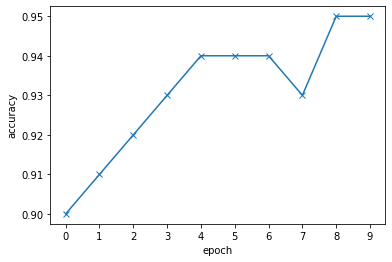

In [19]:
accuracies = [log['accuracy'] for log in logs]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xticks(range(epochs))
plt.show();

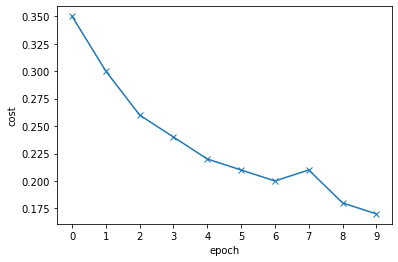

In [20]:
costs = [log['cost'] for log in logs]
plt.plot(costs, '-x')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.xticks(range(epochs))
plt.show();

### 4.3 Predict on test set

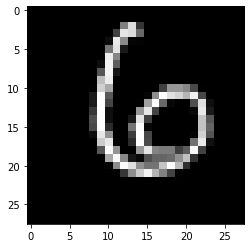

In [21]:
img, label = test_ds[100]
plt.imshow(img[0], cmap='gray');

In [22]:
print("img.device = %s" % img.device)
img = toDevice(img, device)
print("img.device = %s" % img.device)
y_hat = model.predict(img)
print('Label: {}, Predicted: {}'.format(label, y_hat.item()))

img.device = cpu
img.device = cpu
Label: 6, Predicted: 6


### 4.4 Evaluation on test set

In [23]:
test_loader = DeviceDataLoader(test_loader, device)

In [24]:
batch_evals = [model.evaluate(batch) for batch in test_loader]
res = evaluateEpoch(batch_evals)
print('test cost = {}, test accuracy = {}'.format(res['cost'], res['accuracy']))

test cost = 0.15, test accuracy = 0.96
